# **Persiapan Data dan Libraries**

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

In [29]:
# Cek apakah GPU tersedia untuk training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [58]:
# Load SVHN dataset menggunakan PyTorch
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4377, 0.4438, 0.4728], std=[0.1980, 0.2010, 0.1970])  #improved: Normalisasi dengan rata-rata dan deviasi standar untuk RGB
])

In [59]:
# Load dataset SVHN from torchvision
train_set = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transform)
test_set = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transform)

In [32]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)

# **Model CNN**

In [60]:
# Model CNN
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)  # 10 kelas untuk SVHN
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return self.softmax(x)

# **Model MLP (Vanilla)**

In [83]:
# Improved MLP Model
class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 1024)
        self.bn1 = nn.BatchNorm1d(1024)  # Batch Normalization
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)   # Batch Normalization
        self.fc3 = nn.Linear(512, 10)    # 10 classes for SVHN
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)  # Dropout for regularization
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return self.softmax(x)

In [82]:
mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=0.001, weight_decay=1e-4)


# **Fungsi Pelatihan Model**

In [62]:
# Fungsi pelatihan model
def train_model(model, train_loader, optimizer, criterion, device, epochs=10):
    model.train()
    epoch_losses = []
    epoch_accuracies = []
    for epoch in range(epochs):
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Menghitung akurasi
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

        accuracy = correct_preds / total_preds
        epoch_losses.append(running_loss / len(train_loader))
        epoch_accuracies.append(accuracy)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader)}, Accuracy: {accuracy}')

    return epoch_losses, epoch_accuracies

# **Fungsi Evaluasi Model**

In [63]:
# Fungsi evaluasi model
def evaluate_model(model, test_loader, device):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Kelas yang diprediksi
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy())

    return all_labels, all_preds, np.array(all_probs)

# **Evaluasi Matriks dan Persamaan Matematika**

In [64]:
# Menghitung metrik
def calculate_metrics(y_true, y_pred, y_probs):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    # Menghitung AUC dengan probabilitas (bukan kelas yang diprediksi)
    auc = roc_auc_score(y_true, y_probs, multi_class='ovr', average='weighted')

    # Menghitung ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_probs[:, 1], pos_label=1)
    return accuracy, precision, recall, f1, auc, fpr, tpr, thresholds

In [65]:
# Training CNN Model
cnn_model = CNNModel().to(device)
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001, weight_decay=1e-4)
cnn_criterion = nn.CrossEntropyLoss()

cnn_losses, cnn_accuracies = train_model(cnn_model, train_loader, cnn_optimizer, cnn_criterion, device, epochs=10)
y_true, y_pred, y_probs = evaluate_model(cnn_model, test_loader, device)

Epoch [1/10], Loss: 1.9362710344218792, Accuracy: 0.5228851850335121
Epoch [2/10], Loss: 1.6738996164767503, Accuracy: 0.7874742345441391
Epoch [3/10], Loss: 1.6413584305209363, Accuracy: 0.8189797562007726
Epoch [4/10], Loss: 1.6324832876176292, Accuracy: 0.8278799295630451
Epoch [5/10], Loss: 1.6275988643346395, Accuracy: 0.8326712805602196
Epoch [6/10], Loss: 1.6254013411863402, Accuracy: 0.8349509261913537
Epoch [7/10], Loss: 1.6276357559658035, Accuracy: 0.8332582551838049
Epoch [8/10], Loss: 1.6230495194680825, Accuracy: 0.8370804155234312
Epoch [9/10], Loss: 1.6254295090400497, Accuracy: 0.8353331422253164
Epoch [10/10], Loss: 1.6231469190276866, Accuracy: 0.8371486683866388


# **Output CNN Model Metrics**

In [66]:
# Menghitung metrik
cnn_metrics = calculate_metrics(y_true, y_pred, y_probs)

# Output hasil evaluasi
print("CNN Model Metrics")
print(f"Accuracy: {cnn_metrics[0]}")
print(f"Precision: {cnn_metrics[1]}")
print(f"Recall: {cnn_metrics[2]}")
print(f"F1 Score: {cnn_metrics[3]}")
print(f"AUC: {cnn_metrics[4]}")

CNN Model Metrics
Accuracy: 0.8389290104486785
Precision: 0.8455081088299182
Recall: 0.8389290104486785
F1 Score: 0.8385601597994174
AUC: 0.966679265037279


In [88]:
# Training MLP Model
mlp_model = MLPModel().to(device)
mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=0.001, weight_decay=1e-4)  #improved: Menambahkan regularisasi L2
mlp_criterion = nn.CrossEntropyLoss()

mlp_losses, mlp_accuracies = train_model(mlp_model, train_loader, mlp_optimizer, mlp_criterion, device, epochs=10)
y_true_mlp, y_pred_mlp, y_probs_mlp = evaluate_model(mlp_model, test_loader, device)

# Menghitung metrik untuk MLP
mlp_metrics = calculate_metrics(y_true_mlp, y_pred_mlp, y_probs_mlp)

Epoch [1/10], Loss: 2.105244851476761, Accuracy: 0.3515841489550487
Epoch [2/10], Loss: 2.04758476175075, Accuracy: 0.41097779051831224
Epoch [3/10], Loss: 2.027690766732245, Accuracy: 0.43128984260889747
Epoch [4/10], Loss: 2.0083573437674076, Accuracy: 0.45184760500703003
Epoch [5/10], Loss: 1.9998587805110815, Accuracy: 0.4594646245409995
Epoch [6/10], Loss: 1.997058540816911, Accuracy: 0.4625223528127005
Epoch [7/10], Loss: 1.995104899364788, Accuracy: 0.4642423249655323
Epoch [8/10], Loss: 1.9924874881469528, Accuracy: 0.46740925781836545
Epoch [9/10], Loss: 1.9918100500210925, Accuracy: 0.4678460761428942
Epoch [10/10], Loss: 1.9904025026804495, Accuracy: 0.47033048036365127


# **Output MLP Model Metrics**

In [89]:
# Output hasil evaluasi untuk MLP
print("MLP Model Metrics")
print(f"Accuracy: {mlp_metrics[0]}")
print(f"Precision: {mlp_metrics[1]}")
print(f"Recall: {mlp_metrics[2]}")
print(f"F1 Score: {mlp_metrics[3]}")
print(f"AUC: {mlp_metrics[4]}")

MLP Model Metrics
Accuracy: 0.5175169022741242
Precision: 0.5363879265013893
Recall: 0.5175169022741242
F1 Score: 0.494104061143718
AUC: 0.7697125886119625


# **Visualisasi Grafik Perbandingan CNN vs MLP**

In [90]:
# Improved: Plotting Accuracy and Loss Comparison
epochs_range = range(1, 11)
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

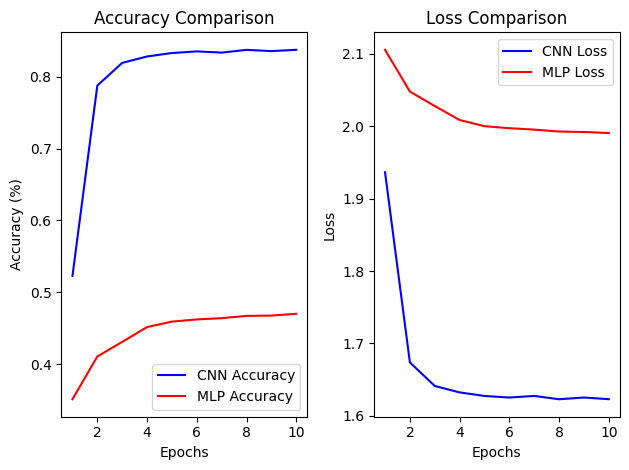

In [91]:
# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, cnn_accuracies, label='CNN Accuracy', color='b')
plt.plot(epochs_range, mlp_accuracies, label='MLP Accuracy', color='r')
plt.title('Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, cnn_losses, label='CNN Loss', color='b')
plt.plot(epochs_range, mlp_losses, label='MLP Loss', color='r')
plt.title('Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### **Analisis dan Penjelasan Proyek CNN vs MLP**

Dalam proyek ini, Ada dua jenis model untuk klasifikasi dataset SVHN (Street View House Numbers): **CNN (Convolutional Neural Network)** dan **MLP (Multilayer Perceptron)**.

### **CNN (Convolutional Neural Network)**:
CNN adalah jenis jaringan saraf yang digunakan untuk pengolahan data gambar. CNN dapat secara otomatis mengekstraksi fitur spasial dari gambar melalui lapisan konvolusi dan pooling, sebelum melakukan klasifikasi pada lapisan fully connected. CNN sangat efektif untuk tugas pengolahan gambar seperti klasifikasi dan deteksi objek.

### **MLP (Multilayer Perceptron)**:
MLP adalah jenis jaringan saraf yang terdiri dari lapisan input, satu atau lebih lapisan tersembunyi, dan lapisan output. MLP digunakan untuk tugas klasifikasi dan regresi. MLP tidak menganggap struktur spasial data dan lebih cocok untuk data tabular atau masalah sederhana.

### **SVHN (Street View House Numbers) Dataset**:
SVHN adalah dataset yang berisi gambar angka rumah dari gambar-gambar yang diambil dari Google Street View. Dataset ini digunakan untuk tugas pengenalan angka, khususnya untuk klasifikasi digit pada gambar yang tidak terstruktur dengan latar belakang yang bervariasi. Setiap gambar di SVHN mengandung angka rumah yang ditulis dalam berbagai kondisi pencahayaan, perspektif, dan gangguan latar belakang. Dataset ini sering digunakan dalam tugas pengolahan gambar dan pengenalan karakter optik (OCR).

#### **Hasil Evaluasi Model**
- **CNN Model Metrics**
  - **Accuracy**: 0.8389
  - **Precision**: 0.8455
  - **Recall**: 0.8389
  - **F1 Score**: 0.8386
  - **AUC**: 0.9667

- **MLP Model Metrics**
  - **Accuracy**: 0.5175
  - **Precision**: 0.5364
  - **Recall**: 0.5175
  - **F1 Score**: 0.4941
  - **AUC**: 0.7697

### **Analisis Model CNN:**

#### 1. **Akurasi (Accuracy)**:
- **Definisi**: Akurasi mengukur seberapa banyak prediksi yang benar dibandingkan dengan total prediksi.


  $$\text{Accuracy} = \frac{\text{Jumlah Prediksi yang Benar}}{\text{Jumlah Total Data}}$$\\
- **Hasil CNN**: Akurasi CNN adalah **83.89%**, yang menunjukkan bahwa model CNN mampu memprediksi dengan benar sekitar 84% dari data uji. Ini adalah hasil yang sangat baik, terutama untuk dataset yang kompleks seperti SVHN.

#### 2. **Presisi (Precision)**:
- **Definisi**: Presisi mengukur proporsi prediksi positif yang benar, yaitu seberapa tepat model mengklasifikasikan data positif.

  $$\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}$$\\
- **Hasil CNN**: Presisi CNN adalah **84.55%**, yang menunjukkan bahwa dari semua prediksi yang diklasifikasikan sebagai positif, sekitar 85% adalah benar.

#### 3. **Recall**:
- **Definisi**: Recall mengukur seberapa banyak data positif yang dapat dikenali dengan benar oleh model. Ini juga dikenal sebagai sensitivitas atau true positive rate.

  $$\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}$$\\
- **Hasil CNN**: Recall CNN adalah **83.89%**, yang berarti model berhasil mengenali sekitar 84% dari semua data positif yang sebenarnya. Ini menunjukkan keseimbangan yang baik antara recall dan presisi.

#### 4. **F1 Score**:
- **Definisi**: F1 Score adalah rata-rata harmonis antara presisi dan recall, memberikan gambaran seimbang dari keduanya.
  $$\text{ Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$\\
- **Hasil CNN**: F1 Score CNN adalah **83.86%**, yang menunjukkan keseimbangan yang sangat baik antara presisi dan recall.

#### 5. **AUC (Area Under Curve)**:
- **Definisi**: AUC mengukur area di bawah kurva ROC (Receiver Operating Characteristic). AUC yang lebih tinggi menunjukkan kemampuan model untuk membedakan antara kelas positif dan negatif.
  
  $$AUC \text{ (ROC)} = \text{Area under the ROC curve}$$\\
  
- **Hasil CNN**: AUC CNN adalah **96.67%**, yang sangat tinggi dan menunjukkan bahwa model CNN memiliki kemampuan yang sangat baik untuk membedakan antara kelas-kelas yang ada.

### **Analisis Model MLP:**

#### 1. **Akurasi (Accuracy)**:

$$\text{Accuracy} = \frac{\text{Jumlah Prediksi yang Benar}}{\text{Jumlah Total Data}}$$\\

- **Hasil MLP**: Akurasi MLP adalah **51.75%**, yang jauh lebih rendah daripada CNN. MLP kesulitan untuk menangani data gambar karena tidak dapat menangkap hubungan spasial antar piksel seperti CNN.

#### 2. **Presisi (Precision)**:

$$\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}$$\\
- **Hasil MLP**: Presisi MLP adalah **53.64%**, yang lebih rendah dari CNN. Ini menunjukkan bahwa dari semua prediksi positif, hanya 54% yang benar, mengindikasikan banyaknya kesalahan klasifikasi pada kelas positif.

#### 3. **Recall**:

$$\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}$$\\
- **Hasil MLP**: Recall MLP adalah **51.75%**, yang berarti MLP hanya mengenali sekitar 52% dari data positif yang sebenarnya. Hal ini menunjukkan bahwa model MLP kesulitan mengenali data positif.

#### 4. **F1 Score**:

$$\text{ Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$\\
- **Hasil MLP**: F1 Score MLP adalah **49.41%**, yang menunjukkan bahwa MLP tidak seimbang dalam mencapai presisi dan recall yang baik. Model ini masih memiliki banyak ruang untuk perbaikan.

#### 5. **AUC (Area Under Curve)**:

$$AUC \text{ (ROC)} = \text{Area under the ROC curve}$$\\
- **Hasil MLP**: AUC MLP adalah **76.97%**, yang jauh lebih rendah dibandingkan dengan CNN. MLP kurang efektif dalam membedakan antara kelas positif dan negatif, meskipun tetap lebih baik daripada model acak.

### **Perbandingan antara CNN dan MLP:**
### Hasil Evaluasi Model

| **Metrik**     | **CNN Model** | **MLP Model** |
|----------------|---------------|---------------|
| **Accuracy**   | 0.8389        | 0.5175        |
| **Precision**  | 0.8455        | 0.5364        |
| **Recall**     | 0.8389        | 0.5175        |
| **F1 Score**   | 0.8386        | 0.4941        |
| **AUC**        | 0.9667        | 0.7697        |

---

- **Akurasi**: CNN jauh lebih unggul dengan **83.89%** dibandingkan MLP yang hanya mencapai **51.75%**. Hal ini mencerminkan kemampuan CNN yang lebih baik dalam menangkap fitur spasial dalam gambar.
- **Presisi dan Recall**: Presisi dan recall CNN lebih baik secara signifikan, masing-masing **84.55%** dan **83.89%**, dibandingkan dengan MLP yang memiliki nilai sekitar **53%** dan **52%**. Ini menunjukkan bahwa CNN lebih baik dalam mengklasifikasikan data positif dan mengidentifikasi kelas yang relevan.
- **F1 Score**: F1 Score CNN (**83.86%**) jauh lebih tinggi dibandingkan dengan MLP (**49.41%**), menunjukkan bahwa CNN memiliki keseimbangan yang lebih baik antara presisi dan recall.
- **AUC**: AUC CNN (**96.67%**) menunjukkan kemampuan klasifikasi yang sangat baik, sedangkan AUC MLP (**76.97%**) menunjukkan bahwa model MLP memiliki performa yang lebih rendah dalam membedakan kelas-kelas.

### **Kesimpulan:**
Model CNN jelas lebih unggul dibandingkan dengan MLP untuk tugas klasifikasi gambar pada dataset SVHN. CNN, dengan kemampuannya dalam menangkap fitur spasial melalui lapisan konvolusi, berhasil mencapai kinerja yang lebih tinggi di hampir semua metrik evaluasi. MLP, yang lebih cocok untuk data tabular, tidak dapat bersaing dengan kemampuan CNN dalam pengolahan gambar, meskipun hasilnya bisa diperbaiki dengan peningkatan arsitektur dan hyperparameter.